In [38]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats

Establish connection.

In [29]:
host = 'localhost'
database = 'Car'
user = 'postgres'
password = 'HarryHogwarts'

engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}')

Get tables. EDA mainly focuses on cars, so this is queried seperately.

In [30]:
query = "SELECT * FROM cars"
cars = pd.read_sql(query, engine)
cars

,car_id,car_name,car_company,max_speed,acceleration,hp,market_price
0,1,Model S,Tesla,250.0,3.2,670.0,106490.00
1,2,Model 3,Tesla,225.0,6.1,NaN,42990.00
2,3,A-Class Limousine,Mercedes,250.0,6.4,224.0,44994.88
3,4,911 Carrera,Porsche,293.0,4.2,385.0,156747.26
4,5,718 Cayman,Porsche,275.0,5.1,300.0,81215.87
5,6,Cayenne,Porsche,248.0,6.0,353.0,118981.27
6,7,Polo,Volkswagen,171.0,NaN,80.0,17990.00
7,8,Golf,Volkswagen,202.0,NaN,110.0,25990.00
8,9,Tiguan,Volkswagen,195.0,NaN,130.0,34480.00
9,10,Roma,Ferrari,320.0,3.4,620.0,NaN


In [31]:
query = "SELECT * \
         FROM cars \
         FULL OUTER JOIN orders \
             ON cars.car_id = orders.car_id \
         FULL OUTER JOIN customers \
             ON orders.customer_id = customers.customer_id"
df = pd.read_sql(query, engine)
# df

Next the column names are changed. Also the id column is dropped.

In [32]:
cars = cars.drop("car_id", axis = 1)
new_col_names = ["Name", "Company", "Maximum_Speed", "Acceleration", "Horsepower", "Market_Price"]
cars.columns = new_col_names

# Exploratory Data Analysis

Frequency of models by car company

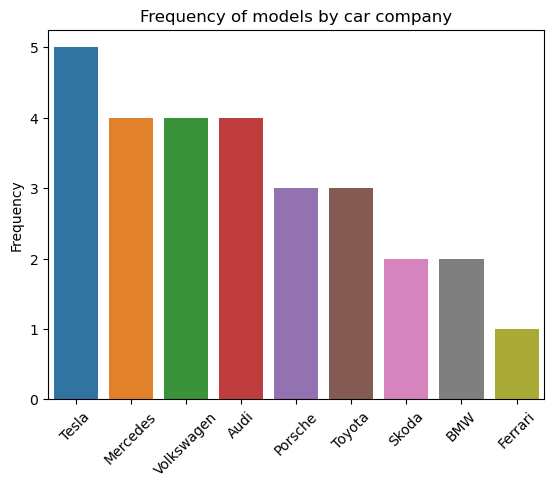

In [33]:
ordered_companies = cars.Company.value_counts().index
sns.countplot(x = cars.Company, order = ordered_companies)
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("Frequency of models by car company")
plt.xticks(rotation=45)
plt.yticks(range(0, 6))
plt.show()

In [34]:
cars.Company.value_counts()

Tesla         5
Mercedes      4
Volkswagen    4
Audi          4
Porsche       3
Toyota        3
Skoda         2
BMW           2
Ferrari       1
Name: Company, dtype: int64

How many NULL values are in the columns?

In [35]:
cars.isnull().sum()

Name             0
Company          0
Maximum_Speed    1
Acceleration     9
Horsepower       3
Market_Price     1
dtype: int64

The following plots from the missingno package visualize the NULL values very well.

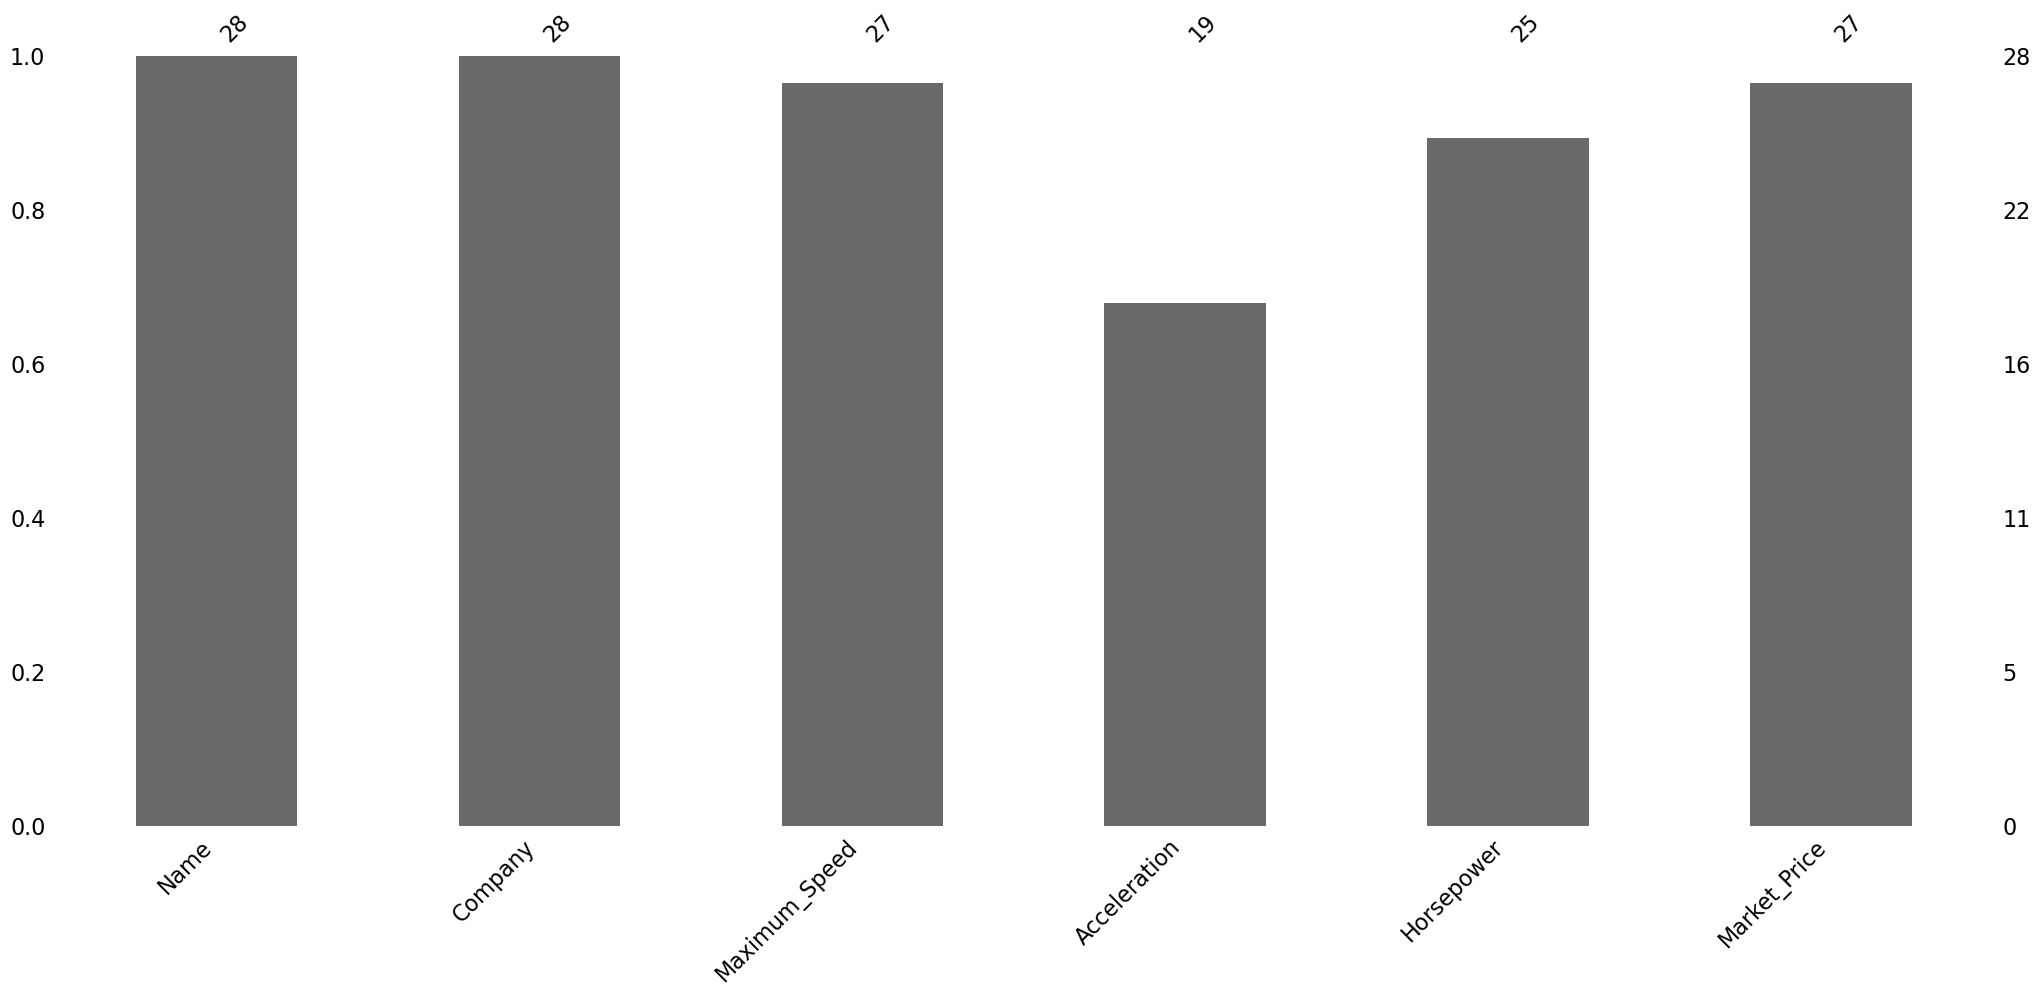

In [36]:
msno.bar(cars)
plt.show()

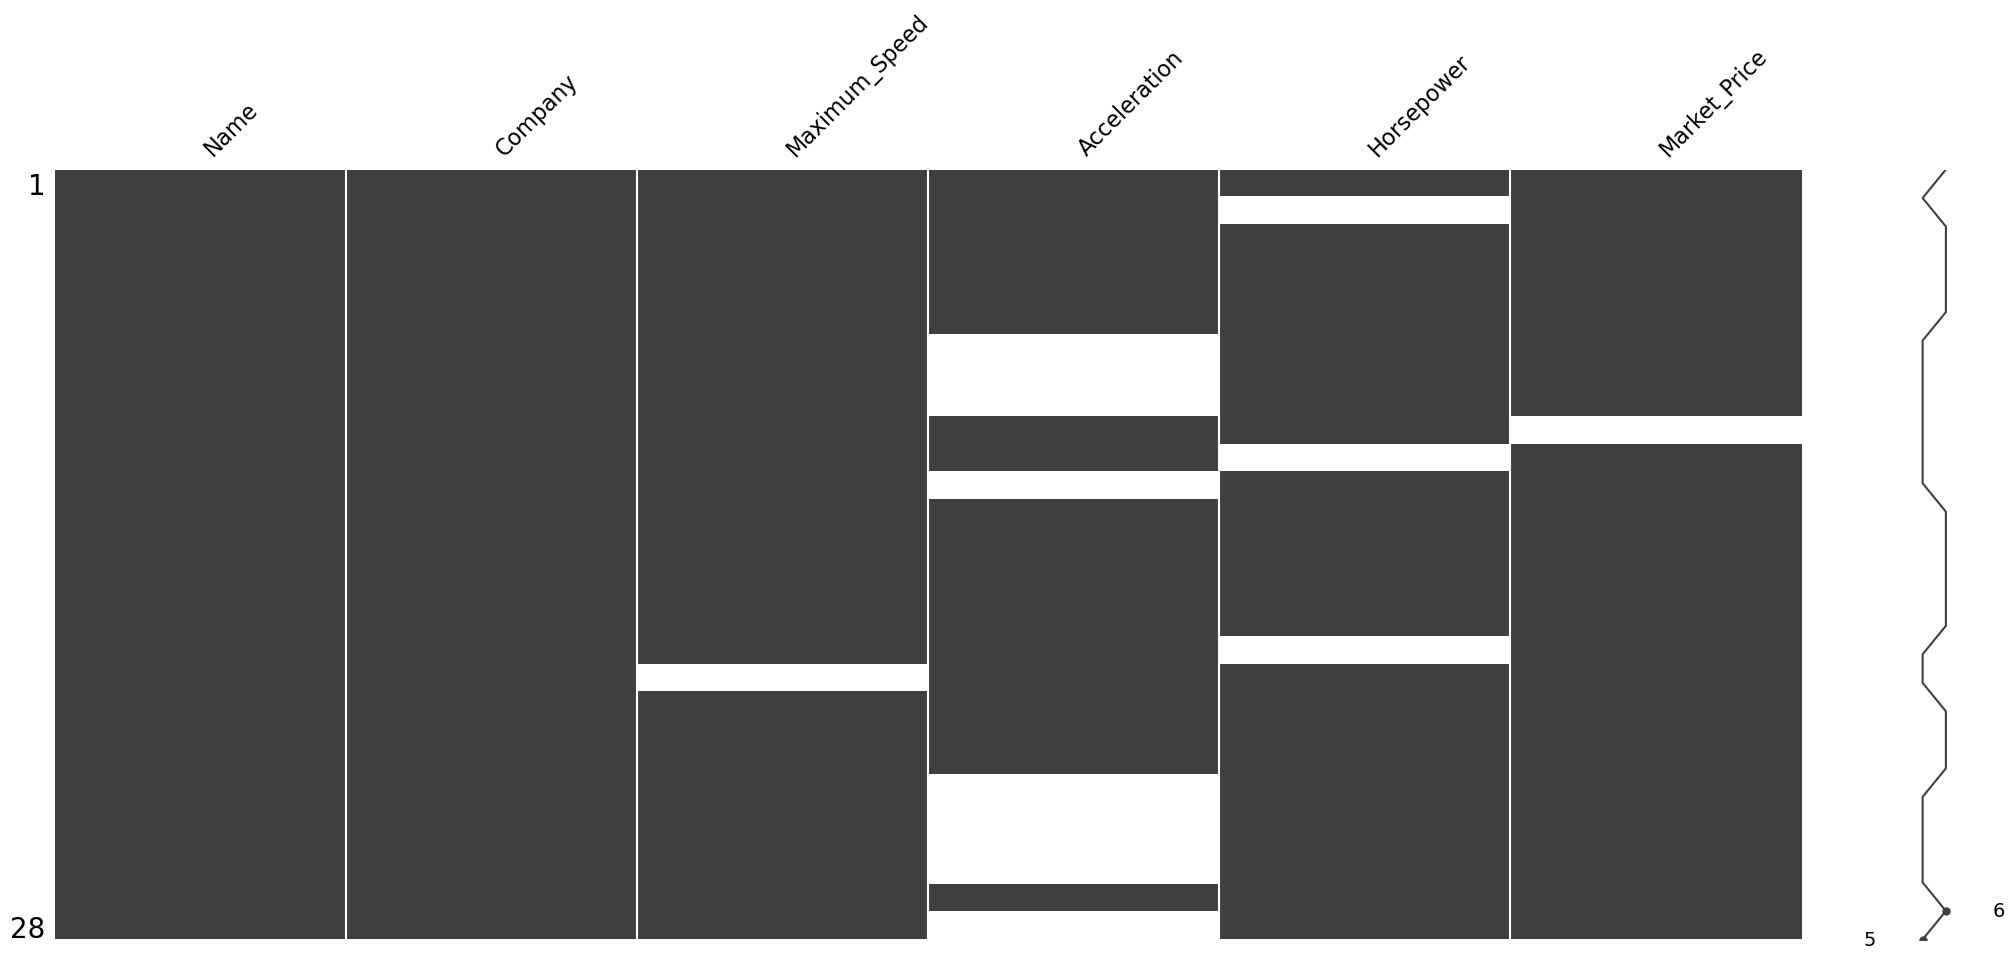

In [37]:
msno.matrix(cars)
plt.show()

Acceleration data is the most incomplete.

And by car company?

In [11]:
cars.groupby("Company").apply(lambda x: x.isnull().any(axis=1).sum())

Company
Audi          4
BMW           0
Ferrari       1
Mercedes      1
Porsche       0
Skoda         2
Tesla         2
Toyota        0
Volkswagen    4
dtype: int64

Audi and Volkswagen have the most incomplete rows.

Next we'll look at the market prices of the models of the companies.

In [12]:
cars_market_price_not_null = cars[cars["Market_Price"].notnull()]

grouped_by_company = cars_market_price_not_null.groupby("Company")["Market_Price"].mean()
ordered_market_price = grouped_by_company.sort_values(ascending=False)

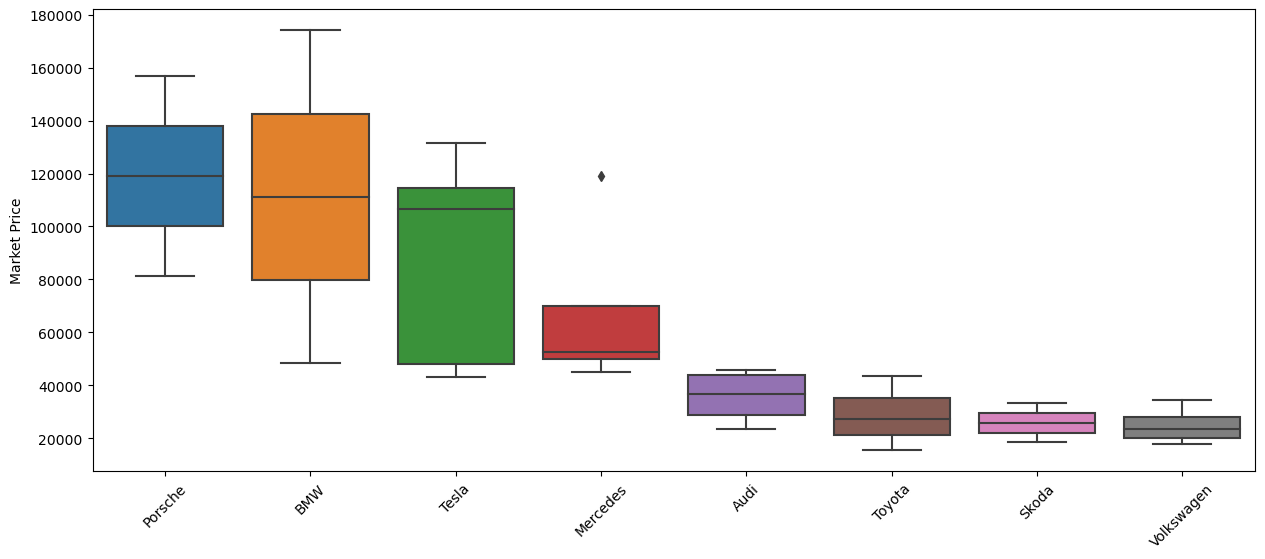

In [13]:
plt.figure(figsize=(15, 6))
sns.boxplot(data = cars_market_price_not_null, x = "Company", y = "Market_Price", order = ordered_market_price.index)
plt.xlabel("")
plt.ylabel("Market Price")
plt.xticks(rotation=45)
plt.show()

There seems to be two different classes: Audi, Toyota, Volkswagen and Skoda produce the cheap cars, the other companies do not. This will be checked out using a t-test. Because the variances are different, Welch's t-test is used.

In [41]:
cheap_cars_list = ["Audi", "Toyota", "Volkswagen", "Skoda"]
cheap_cars = cars_market_price_not_null.loc[cars_market_price_not_null["Company"].isin(cheap_cars_list), ["Company", "Market_Price"]]
expensive_cars = cars_market_price_not_null.loc[~cars_market_price_not_null["Company"].isin(cheap_cars_list), ["Company", "Market_Price"]]

t_statistic, p_value = stats.ttest_ind(cheap_cars.Market_Price, expensive_cars.Market_Price, equal_var=False)
print("Welch's t-statistic:", t_statistic)
print("p-value:", p_value)

Welch's t-statistic: -5.101320235395359
p-value: 0.0001462350145722906


The average market price between these two groups is significant. This difference is visualized in the following plot.

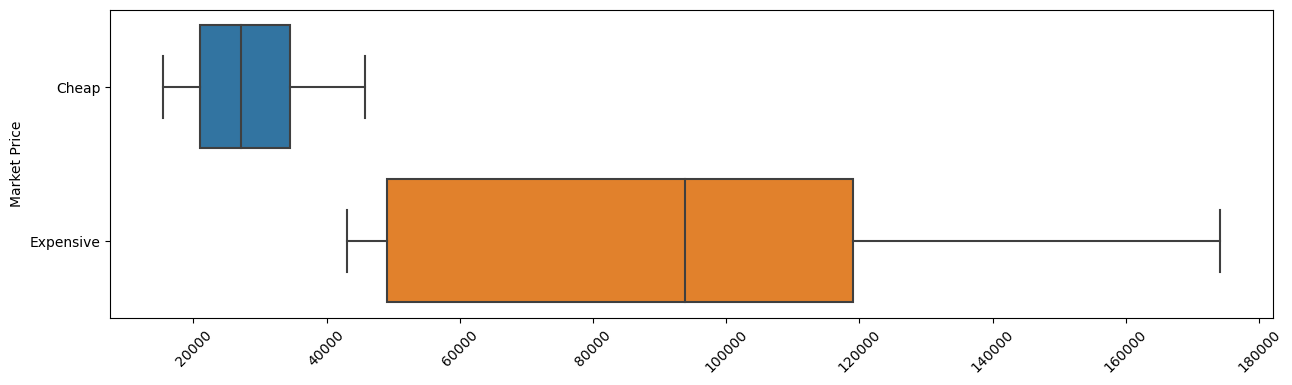

In [62]:
cheap_expensive = pd.DataFrame({"Type": ["Cheap"]*cheap_cars.shape[0] + ["Expensive"]*expensive_cars.shape[0],
                                "Market_Price": pd.concat([cheap_cars.Market_Price, expensive_cars.Market_Price])})

plt.figure(figsize=(15, 4))
sns.boxplot(data = cheap_expensive, y = "Type", x = "Market_Price", orient="h")
plt.xlabel("")
plt.ylabel("Market Price")
plt.xticks(rotation=45)
plt.show()

Next the maximum speed of the cars is investigated.

In [14]:
cars_max_speed_not_null = cars[cars["Maximum_Speed"].notnull()]

grouped_by_company = cars_max_speed_not_null.groupby("Company")["Maximum_Speed"].mean()
ordered_max_speed = grouped_by_company.sort_values(ascending=False)

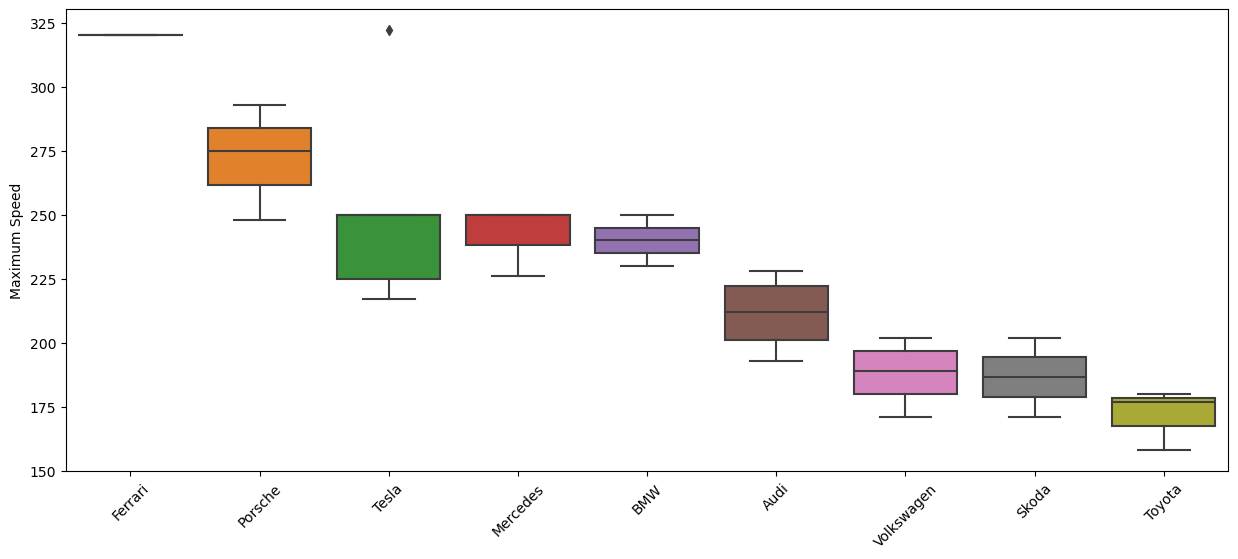

In [15]:
plt.figure(figsize=(15, 6))
sns.boxplot(data = cars_max_speed_not_null, x = "Company", y = "Maximum_Speed", order = ordered_max_speed.index)
plt.xlabel("")
plt.ylabel("Maximum Speed")
plt.xticks(rotation=45)
plt.show()

Finally we look at the acceleration.

In [16]:
cars_acceleration_not_null = cars[cars["Acceleration"].notnull()]

grouped_by_company = cars_acceleration_not_null.groupby("Company")["Acceleration"].mean()
ordered_acceleration = grouped_by_company.sort_values(ascending=True)

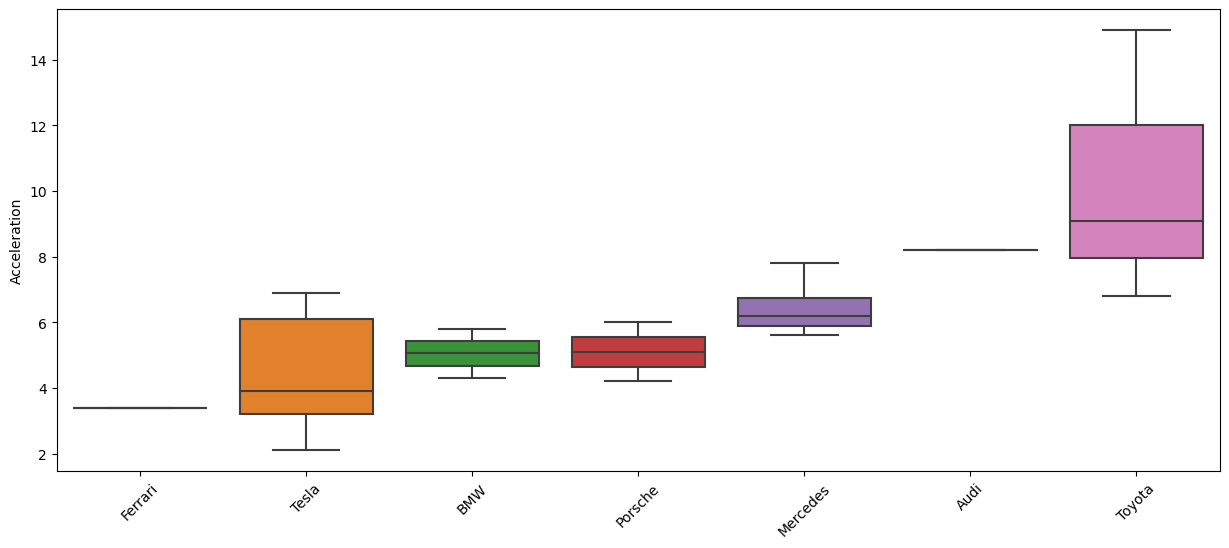

In [17]:
plt.figure(figsize=(15, 6))
sns.boxplot(data = cars_acceleration_not_null, x = "Company", y = "Acceleration", order = ordered_acceleration.index)
plt.xlabel("")
plt.ylabel("Acceleration")
plt.xticks(rotation=45)
plt.show()

Next up is horsepower.

In [18]:
cars_horsepower_not_null = cars[cars["Horsepower"].notnull()]

grouped_by_company = cars_horsepower_not_null.groupby("Company")["Horsepower"].mean()
ordered_horsepower = grouped_by_company.sort_values(ascending=False)

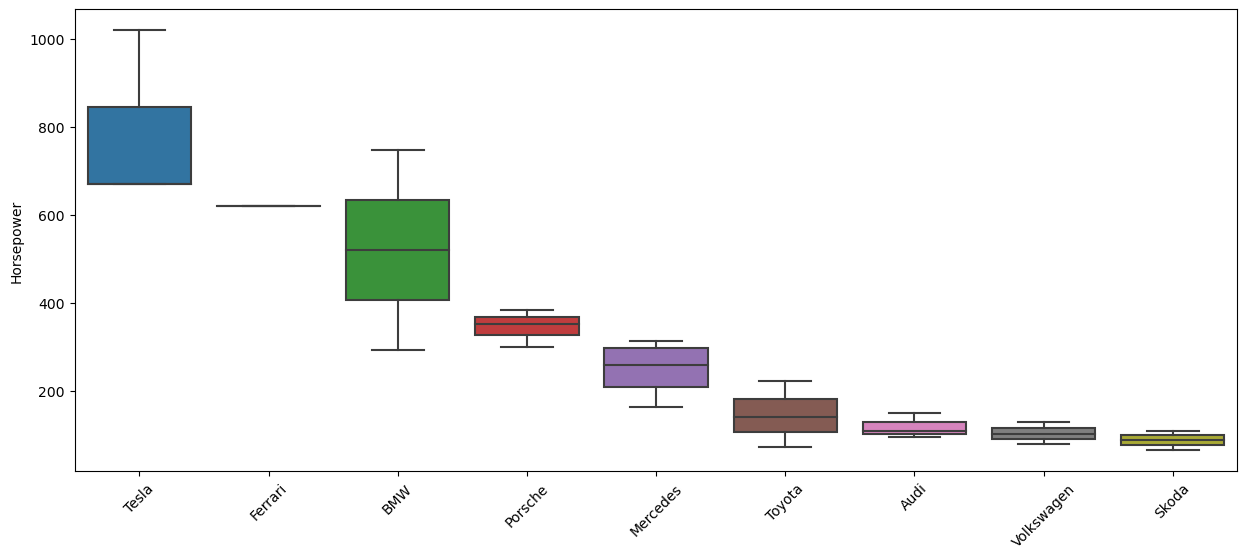

In [19]:
plt.figure(figsize=(15, 6))
sns.boxplot(data = cars_horsepower_not_null, x = "Company", y = "Horsepower", order = ordered_horsepower.index)
plt.xlabel("")
plt.ylabel("Horsepower")
plt.xticks(rotation=45)
plt.show()

What is the relationship between maximum speed and market price? There is a positive relationship, as the correlation coefficient is 0.79.

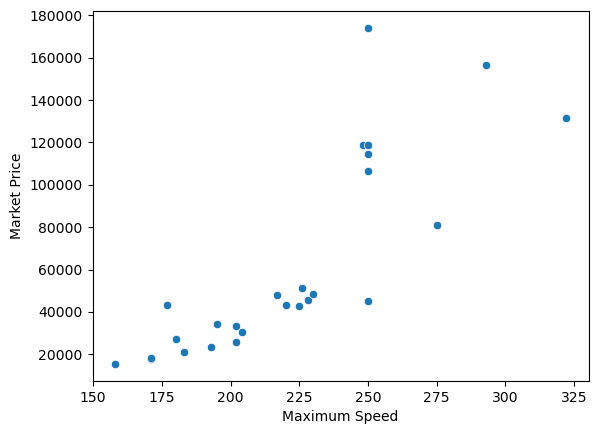

In [21]:
sns.scatterplot(data = cars, x = "Maximum_Speed", y = "Market_Price")
plt.xlabel("Maximum Speed")
plt.ylabel("Market Price")
plt.show()

In [23]:
correlation = cars.Maximum_Speed.corr(cars.Market_Price)
print("Correlation Coefficient:", round(correlation, 2))

Correlation Coefficient: 0.82


In [25]:
from scipy.stats import pearsonr
df = cars[["Maximum_Speed", "Market_Price"]].dropna()
pearsonr(df.Maximum_Speed, df.Market_Price)

PearsonRResult(statistic=0.8166262979863359, pvalue=3.6183960212870295e-07)

What is the relationship between acceleration and market price? There is a negative relationship, as the correlation coefficient is 0.68.

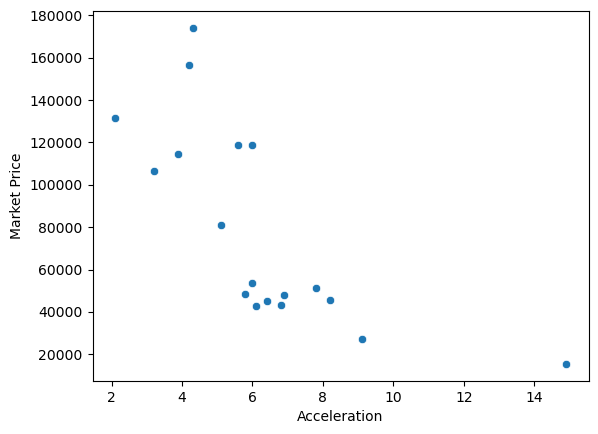

In [ ]:
sns.scatterplot(data = cars, x = "acceleration", y = "market_price")
plt.xlabel("Acceleration")
plt.ylabel("Market Price")
plt.show()

In [ ]:
correlation = cars.acceleration.corr(cars.market_price)
print("Correlation Coefficient:", round(correlation, 2))

Correlation Coefficient: -0.71


What is the relationship between horsepower and market price? There is a positive relationship, as the correlation coefficient is 0.83.

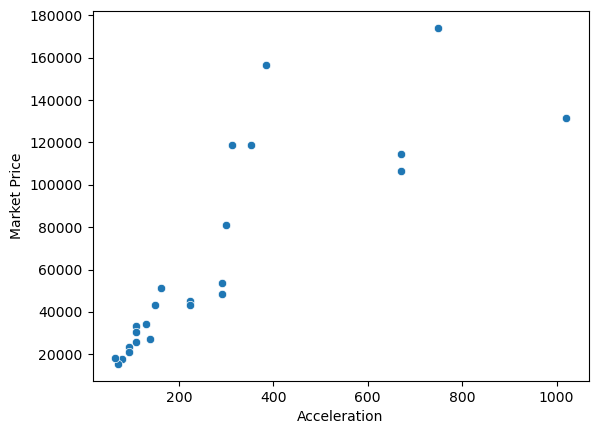

In [26]:
sns.scatterplot(data = cars, x = "Horsepower", y = "Market_Price")
plt.xlabel("Acceleration")
plt.ylabel("Market Price")
plt.show()

In [27]:
correlation = cars.Horsepower.corr(cars.Market_Price)
print("Correlation Coefficient:", round(correlation, 2))

Correlation Coefficient: 0.83


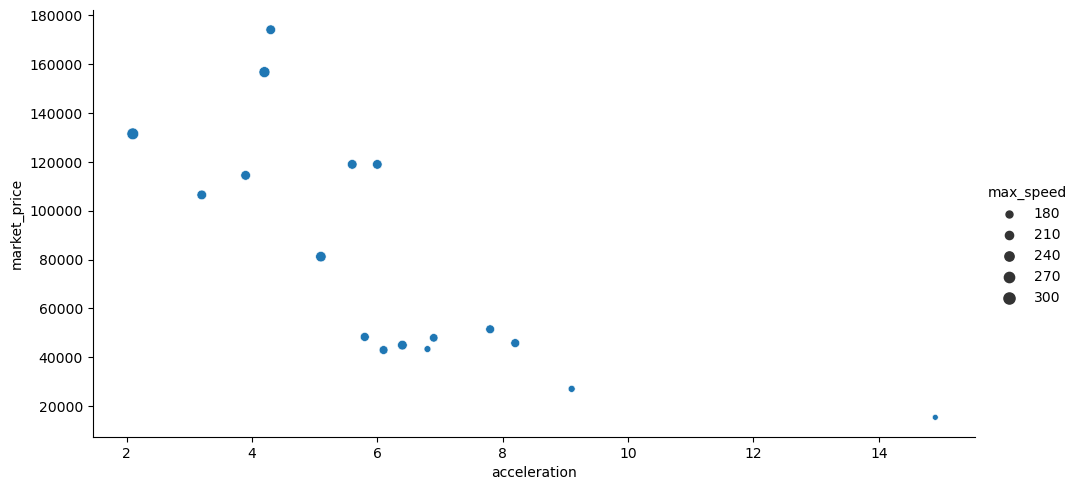

In [ ]:
sns.relplot(data = cars, x = "acceleration", y = "market_price", size = "max_speed", height=5, aspect=2)
plt.show()